In [1]:
# ===== Reduced Order Modeling with NGSolve + pyMOR (POD-Galerkin) =====
from ngsolve import *
from ngsolve import Mesh
from ngsolve import x, y, z
from ngsolve.webgui import Draw
from netgen.geom2d import unit_square
from netgen.occ import *

from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np


In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1,quad_dominated=True))

E = 5e6 # Youngs module
nu = 0.25 # Poisson ratio
lam = E*nu / ((1+nu)*(1-2*nu))
G  = E / (2*(1+nu))

V = VectorH1(mesh, order=2, dirichlet="left")
u, v = V.TnT()

def eps(w):   return 0.5*(Grad(w)+Grad(w).trans)
def sigma(w): return 2*G*eps(w) + lam*Trace(eps(w))*Id(w.dim)

a = BilinearForm(V)
a += InnerProduct(sigma(u), eps(v))*dx

rho, g = 7850, 9.81
f = LinearForm(V)
f += CoefficientFunction((0,-rho*g)) * v * dx

# Assemble & solve 
gfu = GridFunction(V)
a.Assemble(); f.Assemble()
inv = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky")
gfu.vec.data = inv * f.vec

deform = GridFunction(VectorH1(mesh, order=2))


In [3]:
def solve_full(mu_i):
    del_x, del_y = mu_i
    deform.Interpolate((x*y*del_x, x*y*del_y))
    mesh.SetDeformation(deform)

    V = VectorH1(mesh, order=2, dirichlet="left")
    u, v = V.TnT()
    a = BilinearForm(V); a += InnerProduct(sigma(u), eps(v)) * dx
    f = LinearForm(V);   f += CoefficientFunction((0, -rho*g)) * v * dx

    gfu = GridFunction(V)
    a.Assemble(); f.Assemble()
    inv = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky")
    gfu.vec.data = inv * f.vec

    mesh.UnsetDeformation()
    return np.array(gfu.vec), a.mat, np.array(f.vec)

In [ ]:
# parameter grid
DX_MAX, DY_MAX = 0.3, 0.3
N = 8
dx_vals = np.linspace(-DX_MAX, DX_MAX, N)
dy_vals = np.linspace(-DY_MAX, DY_MAX, N)
mu = np.array([(dx, dy) for dx in dx_vals for dy in dy_vals])
max_modes = 100

# collect full-order snapshots and operators
snapshots = []
As = []
fs = []

for mup in mu:
    u_vec, mat, f_vec = solve_full(mup)
    snapshots.append(u_vec)
    As.append(mat)
    fs.append(f_vec)

snapshots = np.array(snapshots)       # shape (nsnaps, ndofs)
nsnaps, ndofs = snapshots.shape

space = NumpyVectorSpace(ndofs)
S = space.make_array(snapshots)       # pyMOR VectorArray

RB, svals = pod(S, modes=min(max_modes, nsnaps))

Vrb = RB.to_numpy().T
r = Vrb.shape[1]

print(f"Modes: {r}, Snapshots: {len(mu)}")

def apply_Acomp(vec_full: np.ndarray, amat):
    vin = amat.CreateColVector()
    vin.FV().NumPy()[:] = vec_full
    vout = amat.CreateColVector()
    vout.data = amat * vin    # assign the expression into vout

    return vout.FV().NumPy().copy()

Ars = []
for mat in As:
    M = np.column_stack([apply_Acomp(Vrb[:, j], mat) for j in range(r)])
    Ar = Vrb.T @ M
    Ars.append(Ar)
    
del As
Ars = np.array(Ars)

frs = []
for f_vec in fs:
    fr = Vrb.T @ f_vec     # shape (r,)
    frs.append(fr)

frs = np.array(frs)        # shape (nsnaps, r)


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Modes: 36, Snapshots: 64


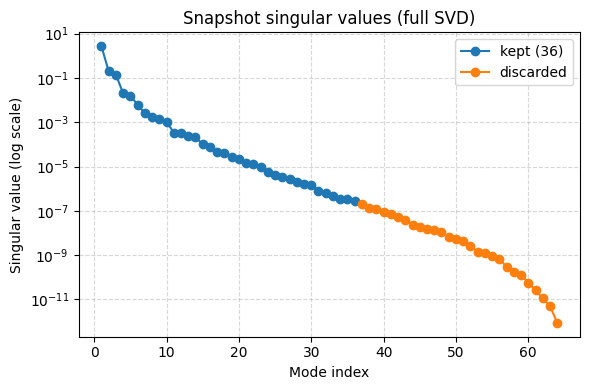

Sum of square singular values beyond cutoff (36): 8.048e-07
S ratio (tail) 2.6068e-07
S ratio (first) (36): 1.0000e+00


In [5]:
# stack snapshots into a matrix: (nsnaps, N)
svals_full = np.linalg.svd(snapshots, compute_uv=False)

# indices
k = np.arange(1, len(svals_full)+1)

plt.figure(figsize=(6,4))
plt.semilogy(k[:r], svals_full[:r], 'o-', color='C0', label=f'kept ({r})')
plt.semilogy(k[r:], svals_full[r:], 'o-', color='C1', label='discarded')

plt.xlabel("Mode index")
plt.ylabel("Singular value (log scale)")
plt.title("Snapshot singular values (full SVD)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

s_squared = svals_full
tail_sum_s_vals = s_squared[r:].sum()
sum_first_r_s_vals = s_squared[:r].sum()

error_ratio_first = sum_first_r_s_vals / s_squared.sum()
error_ratio_tail = tail_sum_s_vals / s_squared.sum()
print(f"Sum of square singular values beyond cutoff ({r}): {tail_sum_s_vals:.3e}")
print(f"S ratio (tail) {error_ratio_tail:.4e}")
print(f"S ratio (first) ({r}): {error_ratio_first:.4e}")
